In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()
    
pipe_vanilla = StableDiffusion3PipelineVanilla.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe_vanilla = pipe_vanilla.to("cuda")

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


Using seed: 1748142510


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


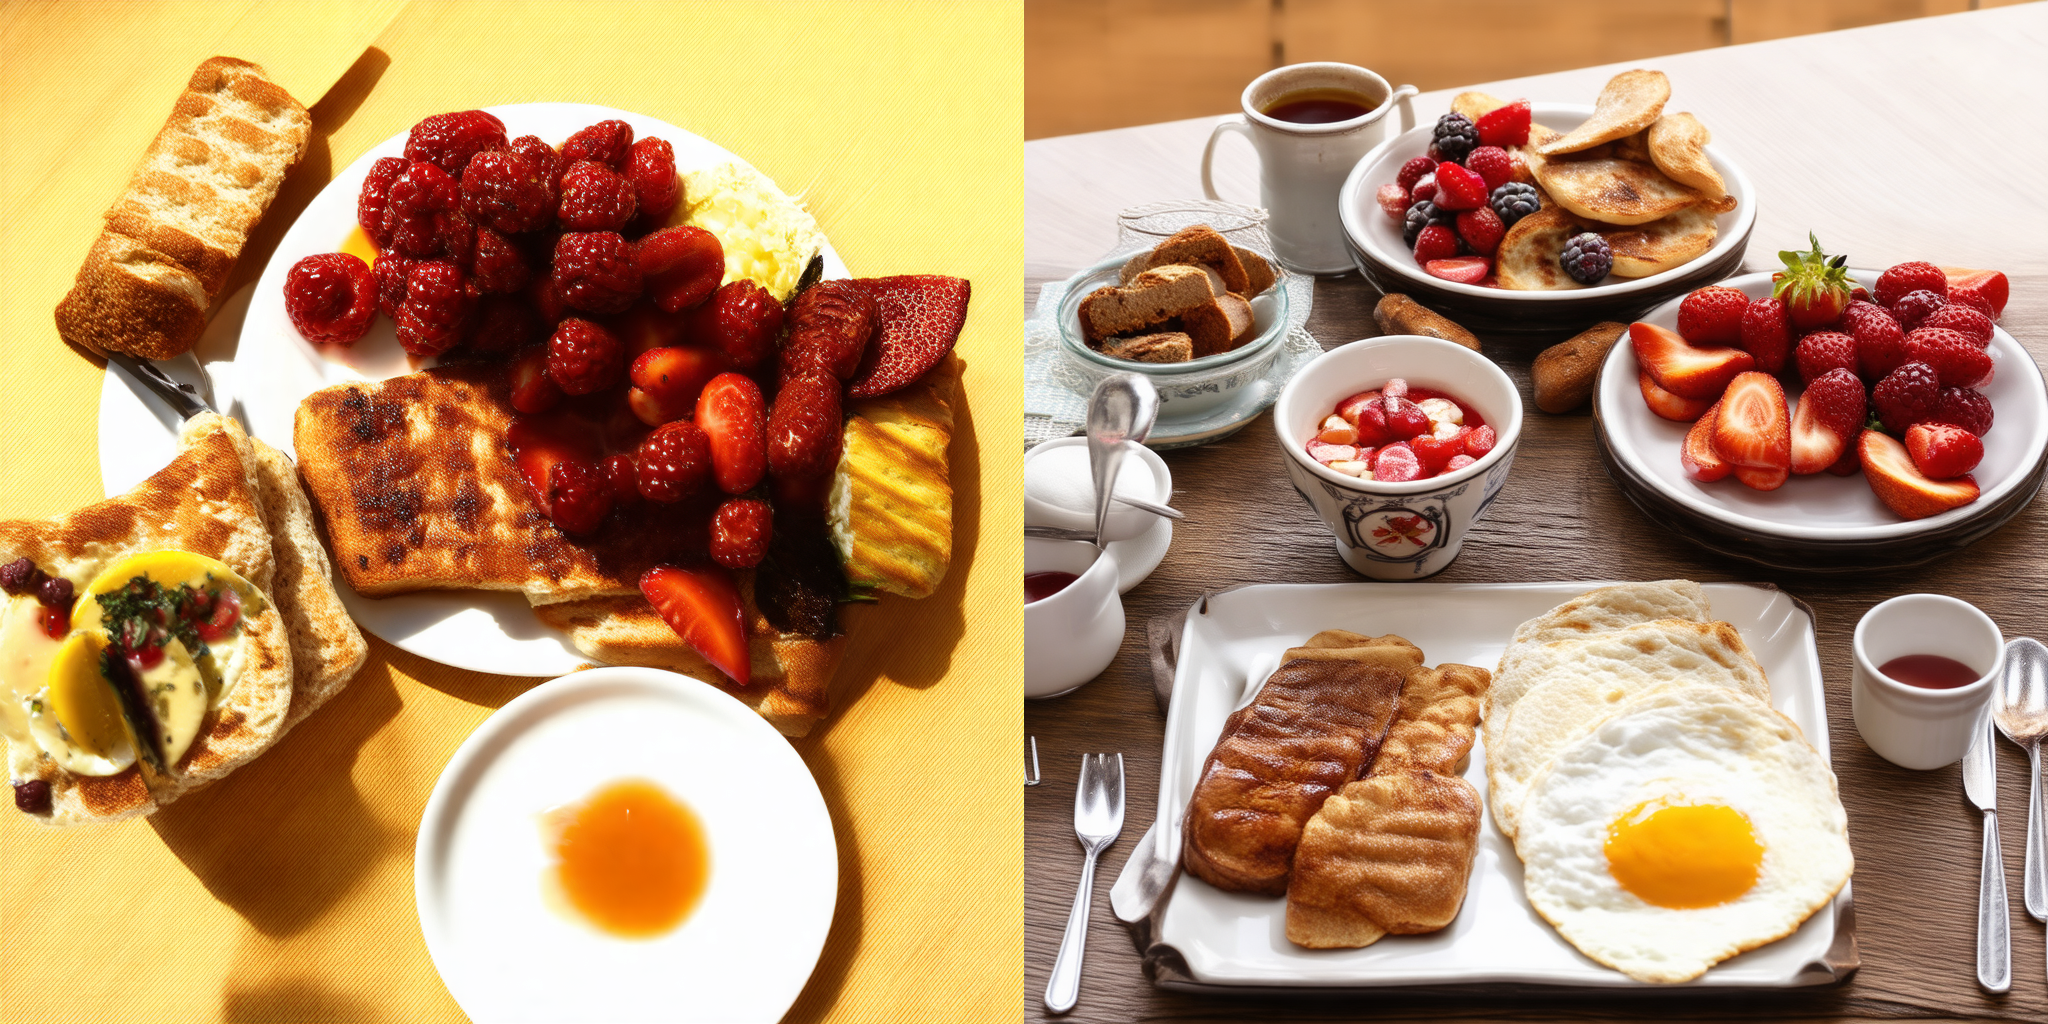

In [7]:
positive_prompt = "A classic British breakfast, featuring a diverse selection of cooked delights, perfect for a filling and flavorful start to the day."
negative_prompt = "egg"
import time
seed = int(time.time())
print(f"Using seed: {seed}")    

for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 


image_ours = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=6.3,
    guidance_scale=7, 
    negative_offset=-4.6,
    clamp_value=13,
    generator=torch.manual_seed(seed),  
).images[0] 
        
image_vanilla = pipe_vanilla(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7, 
    generator=torch.manual_seed(seed),
).images[0]

Image.fromarray(
            np.concatenate(
                [np.array(image_ours), np.array(image_vanilla)], axis=1
            )
 )